In [1]:
import sys
sys.path.insert(1, '../')
sys.path.insert(1, '../../')
import numpy as np
import matplotlib.pyplot as plt
from util.coil import *
import util.mask as undersample
from util.fft import *
import util.simulator as simulate
from util.phantom import * 
from rank import *
import util.io as io
from tqdm.notebook import tqdm
from util.GRAPPA import *
from rank import *
from util.zpad import *

In [2]:
filepath = '../../lib/resource/data/multicoil_1slice/meas_MID308_low_res_2dflash_FID17297.dat'
data = io.getCoilData(filepath)
[ny, nx, nc] =data.shape
acs = simulate.acs(data, (32,32))
print(acs.shape)

pymapVBVD version 0.4.8
Software version: VB


Scan 1/1, read all mdhs:   0%|          | 0.00/33.6M [00:00<?, ?B/s]

read data:   0%|          | 0/256 [00:00<?, ?it/s]

patch taken from 112 : 144 in y
patch taken from 112 : 144 in x
(32, 32, 32)


In [3]:
[ny, nx, nc] = data.shape
acs = simulate.acs(data, (32,32))
kh = 6 
kw = 6
kern = PRUNO_forward(data, kh, kw)
threshold = 0.05

patch taken from 112 : 144 in y
patch taken from 112 : 144 in x


In [4]:
U, S, VT = np.linalg.svd(kern, full_matrices=False)
V = VT.conj().T
S = S/np.max(S)
n = np.sum(S >= threshold * S[0])
V = V[:, -n:]
S = np.diag(S)
print(V.shape)

(1152, 54)


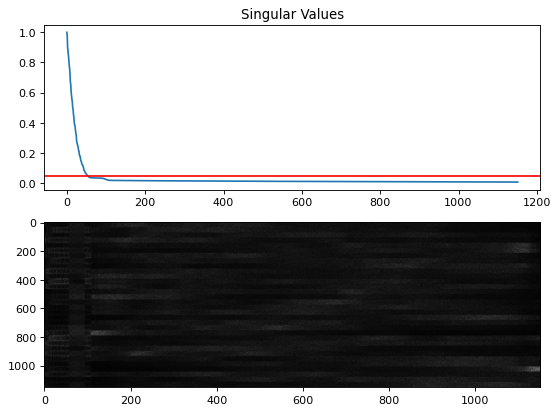

In [5]:
plt.figure(figsize=(8, 6), dpi=80)
plt.subplot(2,1,1)
tmp = np.diag(S)/np.max(np.diag(S))
plt.plot(tmp)
plt.axhline(y=tmp[n-1], color='r', linestyle='-')
plt.title('Singular Values')
plt.subplot(2,1,2)
plt.imshow(np.abs(np.transpose(VT)),aspect='auto', cmap = "gray")
plt.show()

In [6]:
kern = V.reshape(nc, kh, kw, n)
kern = np.moveaxis(kern, 0, -2)
kern = kern[::-1,::-1,:,:].conj()
kern = zpad(kern.conj(), (256,256), (0,1))
kern = ifft2c(kern)/ np.sqrt(kh * kw)

In [7]:
sensmap = np.zeros([ny, nx, nc, nc], dtype = complex)
for y in range(ny):
    for x in range(nx):
        u, s, vT = np.linalg.svd(kern[y, x, ...], full_matrices=True)
        for c in range(nc):
            c = np.argmin(s)
            sensmap[y, x,:,:] = u[:,:]

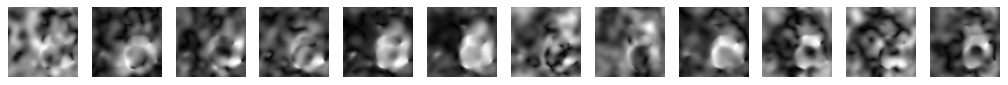

In [8]:
plt.figure(figsize=(16, 12), dpi=80)
for idx in range(12):
    plt.subplot(1, 12, idx+1)
    plt.imshow(np.abs(sensmap[:,:,idx, 0]), cmap='gray')
    plt.axis('off')
plt.show()

In [9]:
img = np.zeros([ny,nx, nc], dtype = complex)
tmp = sensmap[:,:,:,0]
img[:,:,c] = np.sum(tmp*ifft2c(data), axis =2)  

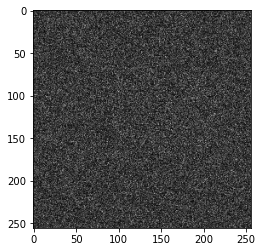

In [10]:
showrsos(img)

In [11]:
mask = np.zeros([ny, nx, nc], dtype = complex)
mask[::2] = 1
dataR = data * mask

In [13]:
img = np.zeros([ny,nx, nc], dtype = complex)
tmp = sensmap[:,:,:,0]
img[:,:,c] = np.sum(tmp*ifft2c(dataR), axis =2)  

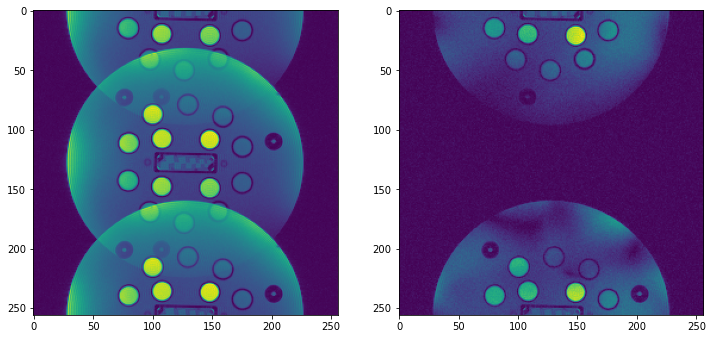

In [16]:
plt.figure(figsize=(12,8))
plt.subplot(121)
plt.imshow(rsos(ifft2c(dataR)))
plt.subplot(122)
plt.imshow(rsos(img))